<h1><center>Classificação: K-Nearest Neighbors</center></h1>

Nesta aula iremos aprender a como utilizar o scikit-learn para definir o segmento a que pertence um cliente com base nos vizinhos mais próximos. Utilizaremos a técnica de K-Nearest Neighbors.

# Importando os pacotes necessários

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing

# Download dos dados
O download dos dados pode ser realizado por meio do IBM Object Storage, disponível em:

https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv

##### Obs.: O arquivo deve ser salvo na mesma pasta onde este arquivo estiver salvo.


<h2>Entendendo os dados</h2>

Imagine que um provedor de telecomunicações tenha segmentado sua base de clientes por padrões de uso de serviço, classificando os clientes em quatro grupos. Se os dados demográficos puderem ser usados para prever a associação ao grupo, a empresa poderá personalizar ofertas para clientes em potencial individuais. É um problema de classificação. Ou seja, dado o conjunto de dados, com rótulos predefinidos, precisamos construir um modelo a ser usado para prever a classe de um caso novo ou desconhecido.

O exemplo se concentra no uso de dados demográficos, como região, idade e relacionamento, para prever padrões de uso.

O campo de destino, chamado __custcat__, possui quatro valores possíveis que correspondem aos quatro grupos de clientes, da seguinte maneira:
  1- Basic Service
  2- E-Service
  3- Plus Service
  4- Total Service

Nosso objetivo é construir um classificador, para prever a classe de casos desconhecidos. Usaremos um tipo específico de classificação chamado K-Nearest Neighbour.

<h2>Lendo os dados</h2>

In [2]:
df = pd.read_csv("csv/teleCust1000t.csv")

# Exibir o cabeçalho do arquivo
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


# Visualização e Análise dos Dados
Vamos visualizar quantas classes temos nos nossos dados:

In [4]:
df['custcat'].value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

Você pode facilmente explorar os dados usando técnicas de visualização:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CBA687F438>]],
      dtype=object)

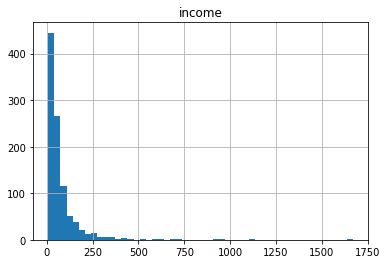

In [5]:
df.hist(column='income', bins=50)

# Conjunto de Características
Vamos definir o conjunto de características, X:

In [6]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

Para usar a biblioteca scikit-learn, temos que converter o conjunto de dados do Pandas em um array Numpy:

In [7]:
X = df[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']] .values  #.astype(float)
X[0:5]

array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.]])

Quais são nossos dados?

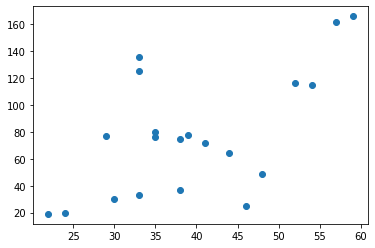

In [8]:
age = df['age'].values
income = df['income'].values
y = df['custcat'].values
y[0:20]
age[0:20]
income[0:20]
plt.scatter(age[0:20], income[0:20])

# Normalizando os Dados
A normalização dos dados fornece dados com média zero e variância unitária, é uma boa prática, especialmente para algoritmos como o KNN, que é baseado na distância dos casos:

In [9]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.02696767, -1.055125  ,  0.18450456,  1.0100505 , -0.25303431,
        -0.12650641,  1.0877526 , -0.5941226 , -0.22207644, -1.03459817,
        -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243,  1.0100505 , -0.4514148 ,
         0.54644972,  1.9062271 , -0.5941226 , -0.22207644, -1.03459817,
         2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601,  1.0100505 ,  1.23481934,
         0.35951747, -1.36767088,  1.78752803, -0.22207644,  0.96655883,
        -0.23065004],
       [-0.02696767, -0.11831864, -0.69181243, -0.9900495 ,  0.04453642,
        -0.41625141, -0.54919639, -1.09029981, -0.22207644,  0.96655883,
        -0.92747794],
       [-0.02696767, -0.58672182, -0.93080797,  1.0100505 , -0.25303431,
        -0.44429125, -1.36767088, -0.89182893, -0.22207644, -1.03459817,
         1.16300577]])

# Criando os dados de treinamento e de validação
A Exatidão Fora da Amostra  é a porcentagem de previsões corretas que o modelo faz em dados nos quais o modelo __NÃO__ foi treinado. Fazer o treinamento e a validação com o mesmo conjunto de dados provavelmente resultará baixa exatidão fora da amostra, devido à probabilidade de excesso de ajuste.

É importante que nossos modelos tenham uma alta exatidão fora da amostra, porque o objetivo de qualquer modelo, é claro, é fazer previsões corretas sobre dados desconhecidos. Então, como podemos melhorar a exatidão fora da amostra? Uma maneira é usar uma abordagem de avaliação denominada Divisão de Treinamento / Validação.
A divisão de treinamento / validação envolve a divisão do conjunto de dados em conjuntos de treinamento e validação, respectivamente, que são mutuamente exclusivos. Depois disso, você treina com o conjunto de treinamento e valida com o conjunto de validação.

Isso fornecerá uma avaliação mais precisa da exatidão fora da amostra, porque o conjunto de dados de validação não faz parte do conjunto de dados que foi usado para treinar os dados. É mais realista para problemas do mundo real.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800, 11) (800,)
Test set: (200, 11) (200,)


# Classificação
## K-Nearest Neighbor (KNN)
### Importando os módulos

Classificador utilizando KNN:

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Treinamento
Vamos começar a utilizar o algoritmo com $k=4$:

In [12]:
k = 4
#Modelo de Treinamento e Predição  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

# Predição
Podemos utilizar o modelo para prever os dados de validação:

In [13]:
yhat = neigh.predict(X_test)
yhat[0:50]

array([1, 1, 3, 2, 4, 3, 3, 2, 2, 4, 1, 4, 2, 1, 3, 1, 3, 4, 3, 4, 3, 3,
       3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 4, 4, 3, 2, 3, 1, 2, 3, 1, 4, 2, 1,
       2, 1, 4, 1, 4, 4], dtype=int64)

# Avaliação de exatidão
Na classificação multiclasse, __accuracy classification score__ é uma função que calcula a exatidão do subconjunto. Essa função é igual à função __jaccard_similarity_score__. Essencialmente, ele calcula com que precisão os rótulos reais e os rótulos previstos são correspondidos no conjunto de validação.

In [14]:
from sklearn import metrics
print("Exatidão dos Dados de Treinamento: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Exatidão dos Dados de Validação: ", metrics.accuracy_score(y_test, yhat))


Exatidão dos Dados de Treinamento:  0.5475
Exatidão dos Dados de Validação:  0.32


# Prática
Você pode construir o modelo novamente, mas desta vez com k = 6?


In [23]:
# Escreva seu código aqui

n_k = 15

for k_linha in range(1, n_k):
    
    #Separando dados de treinamento evalidação
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
    
    #Modelo de Treinamento  
    neigh = KNeighborsClassifier(n_neighbors = k_linha).fit(X_train,y_train)
    neigh

    #Predição
    yhat = neigh.predict(X_test)
    yhat[0:50]

    #Resultados
    print("Para k = ", k_linha)
    print("Exatidão dos Dados de Treinamento : ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
    print("Exatidão dos Dados de Validação: ", metrics.accuracy_score(y_test, yhat))


Para k =  1
Exatidão dos Dados de Treinamento :  1.0
Exatidão dos Dados de Validação:  0.3
Para k =  2
Exatidão dos Dados de Treinamento :  0.6175
Exatidão dos Dados de Validação:  0.29
Para k =  3
Exatidão dos Dados de Treinamento :  0.56875
Exatidão dos Dados de Validação:  0.315
Para k =  4
Exatidão dos Dados de Treinamento :  0.5475
Exatidão dos Dados de Validação:  0.32
Para k =  5
Exatidão dos Dados de Treinamento :  0.5375
Exatidão dos Dados de Validação:  0.315
Para k =  6
Exatidão dos Dados de Treinamento :  0.51625
Exatidão dos Dados de Validação:  0.31
Para k =  7
Exatidão dos Dados de Treinamento :  0.5125
Exatidão dos Dados de Validação:  0.335
Para k =  8
Exatidão dos Dados de Treinamento :  0.4925
Exatidão dos Dados de Validação:  0.325
Para k =  9
Exatidão dos Dados de Treinamento :  0.5025
Exatidão dos Dados de Validação:  0.34
Para k =  10
Exatidão dos Dados de Treinamento :  0.4875
Exatidão dos Dados de Validação:  0.33
Para k =  11
Exatidão dos Dados de Treinamento 

Duplo-clique __aqui__ para a solução.

<!-- Resposta abaixo:

k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))

-->

#### E quanto a outro valor de K?
K em KNN, é o número de vizinhos mais próximos a examinar. Ele deve ser especificado pelo usuário. Então, como podemos escolher o valor certo para K?
A solução geral é reservar uma parte dos seus dados para testar a precisão do modelo. Em seguida, escolha k = 1, use a parte de treinamento para modelagem e calcule a precisão da previsão usando todas as amostras do seu conjunto de teste. Repita este processo, aumentando o k e veja qual é o melhor para o seu modelo.

Podemos calcular a precisão do KNN para diferentes Ks.

In [26]:
Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Modelo de treinamento e validação  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.3  , 0.29 , 0.315, 0.32 , 0.315, 0.31 , 0.335, 0.325, 0.34 ,
       0.33 , 0.315, 0.34 , 0.33 , 0.315, 0.34 , 0.36 , 0.355, 0.35 ,
       0.345, 0.335, 0.35 , 0.36 , 0.37 , 0.365, 0.365, 0.365, 0.35 ,
       0.36 , 0.38 , 0.385, 0.395, 0.395, 0.38 , 0.37 , 0.365, 0.385,
       0.395, 0.41 , 0.395, 0.395, 0.395, 0.38 , 0.39 , 0.375, 0.365,
       0.38 , 0.375, 0.375, 0.365])

#### Precisão do modelo de plotagem para diferentes números de vizinhos

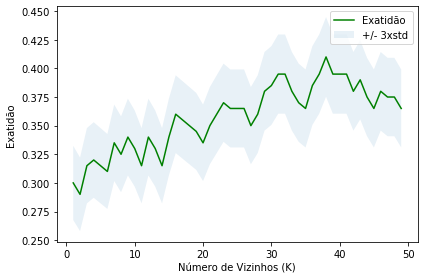

In [27]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Exatidão ', '+/- 3xstd'))
plt.ylabel('Exatidão ')
plt.xlabel('Número de Vizinhos (K)')
plt.tight_layout()
plt.show()

Esta aula foi desenvolvida com base no material disponibilizado por Saeed Aghabozorgi

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>